In [49]:
import torchvision
from torchvision import  transforms
import torch
from torch import no_grad

In [50]:
import requests

In [51]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def get_predictions(pred, threshold=0.8, objects=None):
    """
    This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold

    pred: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class yhat, probability of belonging to that class and the coordinates of the bounding box corresponding to the object
    image : frozen surface
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object
    thre
    """


    predicted_classes= [(COCO_INSTANCE_CATEGORY_NAMES[i],p,[(box[0], box[1]), (box[2], box[3])]) for i,p,box in zip(list(pred[0]['labels'].numpy()),pred[0]['scores'].detach().numpy(),list(pred[0]['boxes'].detach().numpy()))]
    predicted_classes=[  stuff  for stuff in predicted_classes  if stuff[1]>threshold ]

    if objects  and predicted_classes :
        predicted_classes=[ (name, p, box) for name, p, box in predicted_classes if name in  objects ]
    return predicted_classes

In [53]:
def draw_box(pred_class, img, rect_th=2, text_size=0.5, text_th=2, download_image=False, img_name="img"):
    """
    draws box around each object

    predicted_classes: a list where each element contains a tuple that corresponds to information about the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object
    image : frozen surface

    """
    image = (np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8).copy()

    for predicted_class in pred_class:

      label=predicted_class[0]
      probability=predicted_class[1]
      box=predicted_class[2]
      t = round(box[0][0].tolist())
      l = round(box[0][1].tolist())
      r = round(box[1][0].tolist())
      b = round(box[1][1].tolist())

      # Giving brief information about rectange, class and probability.
      from colorama import Fore
      from colorama import Style
      print(f"\nLabel: {Fore.GREEN}{label}{Style.RESET_ALL}")
      print(f"Box coordinates: {t}, {l}, {r}, {b}")
      print(f"Probability: {probability}")

      # Drawing rectangle and adding text on the picture based on their class and size.
      cv2.rectangle(image, (t, l), (r, b), (0, 255, 0), rect_th)
      cv2.rectangle(image, (t, l), (t+110, l+17), (255, 255, 255), -1)
      cv2.putText(image, label, (t+10, l+12),  cv2.FONT_HERSHEY_SIMPLEX,
                  text_size, (0,255,0), thickness=text_th)
      cv2.putText(image, label+": "+str(round(probability, 2)),
                  (t+10, l+12),  cv2.FONT_HERSHEY_SIMPLEX, text_size,
                  (0, 255, 0),thickness=text_th)

    # Plotting image
    image = np.array(image)
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if download_image:
      plt.savefig(f'{img_name}.png')
    else:
      pass
    plt.show()

    del(img)
    del(image)

In [54]:
def crop_and_save(pred_class, img, output_dir="cropped_items", img_prefix="item"):
    """
    Crops and saves each detected object from the image.
    
    pred_class: List of tuples containing class name, probability, and bounding box.
    img: Original image (in tensor format).
    output_dir: Directory where cropped images will be saved.
    img_prefix: Prefix for the cropped images filenames.
    """
    # Ensure output directory exists
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Convert the tensor image to a NumPy array
    image_np = (img.numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
    
    # Iterate over all detected objects
    for idx, predicted_class in enumerate(pred_class):
        label = predicted_class[0]
        box = predicted_class[2]
        
        # Extract box coordinates
        t = round(box[0][0].tolist())  # Top (Y1)
        l = round(box[0][1].tolist())  # Left (X1)
        r = round(box[1][0].tolist())  # Right (X2)
        b = round(box[1][1].tolist())  # Bottom (Y2)
        
        # Crop the image based on the bounding box
        cropped_img = image_np[l:b, t:r]
        
        # Create file path for saving the cropped image
        img_name = f"{output_dir}/{img_prefix}_{label}_{idx}.jpg"
        
        # Save the cropped image using PIL
        cropped_pil_img = Image.fromarray(cropped_img)
        cropped_pil_img.save(img_name)
        
        print(f"Saved cropped image of {label} at {img_name}")


In [55]:
def save_RAM(image_=False):
    global image, img, pred
    torch.cuda.empty_cache()
    del(img)
    del(pred)
    if image_:
        image.close()
        del(image)

In [56]:
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()

for name, param in model_.named_parameters():
    param.requires_grad = False
print("done")

done


In [57]:
def model(x):
    with torch.no_grad():
        yhat = model_(x)
    return yhat

In [58]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

In [59]:
from pathlib import Path
print("Directory Path:", Path().absolute())

Directory Path: /teamspace/studios/this_studio


In [60]:
transform = transforms.Compose([transforms.ToTensor()])

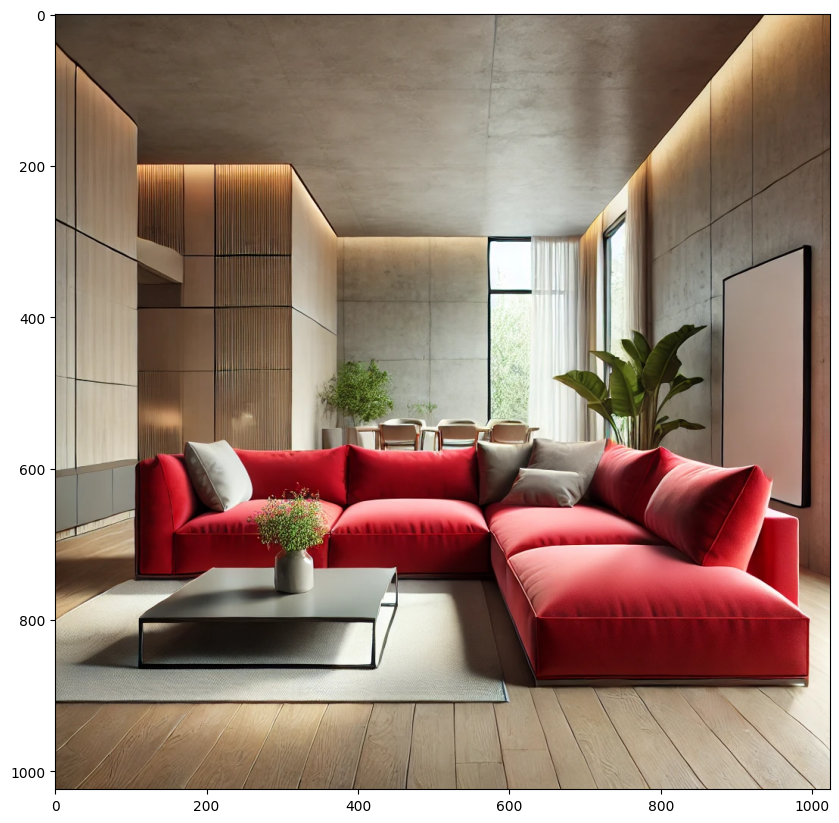

In [61]:
img_path = './sdp2/test/lsofa2.jpg'
image = Image.open(img_path)
plt.figure(figsize=(10, 15))
plt.imshow(np.array(image))
plt.show()


Label: chair
Box coordinates: 423, 536, 487, 579
Probability: 0.990695595741272

Label: couch
Box coordinates: 98, 553, 986, 884
Probability: 0.9855915307998657

Label: chair
Box coordinates: 501, 537, 561, 577
Probability: 0.9500347971916199

Label: couch
Box coordinates: 109, 559, 771, 761
Probability: 0.9202206134796143


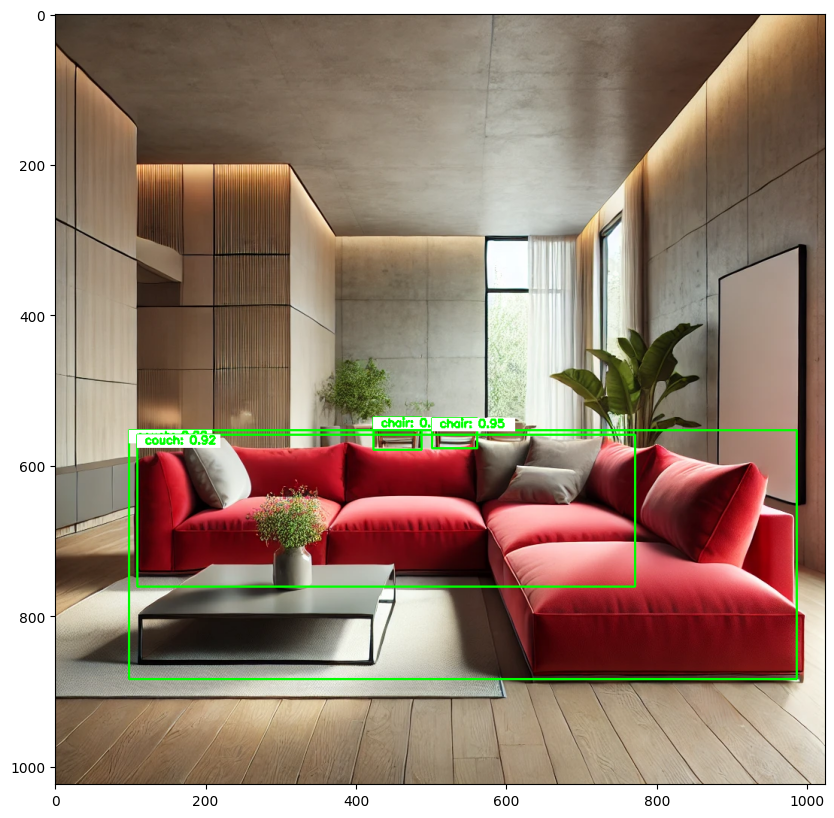

Saved cropped image of chair at cropped_items/item_chair_0.jpg
Saved cropped image of couch at cropped_items/item_couch_1.jpg
Saved cropped image of chair at cropped_items/item_chair_2.jpg
Saved cropped image of couch at cropped_items/item_couch_3.jpg


In [62]:
img = transform(image)
pred = model(img.unsqueeze(0))
pred_thresh=get_predictions(pred)
objects_of_interest = ["bed", "dining table", "chair", "couch"]
pred_class = get_predictions(pred, objects=objects_of_interest)
draw_box(pred_class, img.squeeze(0)) 
crop_and_save(pred_class, img.squeeze(0))